In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
import ares

In [2]:
#loading the EDGES data (the e subscipt is related to EDGES)
data_1 = pd.read_csv('data_1.csv')
freq_e = data_1.iloc[:,0] #frequency, MHz
data_e = data_1.iloc[:,6] #model, mK
model_e = data_1.iloc[:,5] #model, mK

#Changing the axis from frequency to redshift
v_0 = 1420 #MHz, frequency of 21cm line
z_e = (v_0/freq_e)-1 #conversion of frequency to redshift

#converting the data from k to mk
data_e = data_e*1000
model_e = model_e*1000

In [3]:
def dict_to_list(d): #converts dictionary to two lists (key and value)
    #d must be a dictionary containing the value of parameters and their names
    key = list(d.keys())
    value = list(d.values())
    return value, key

def list_to_dict(value, key): #converts two lists (key and value) to a dictionary
    #value is a list of parameters' values
    #key is a list of parameters' names
    return dict(zip(key, value))

def call_ares (params, redshifts): 
    #params should be a dictionary
    
    sim = ares.simulations.Global21cm(**params, verbose=False, progress_bar=False)
    sim.run()
    z = sim.history['z'][::-1]
    dTb = sim.history['dTb'][::-1]
    z = z[z<50]
    dTb = dTb[:len(z)]
    spline = CubicSpline(z, dTb)
    
    return spline(redshifts)

def chisquare (pars, data, Ninv): #returns the chi-square of two 21cm curves - err can be a number/array   
    try:
        pred = call_ares(list_to_dict(pars, key), z_e)
        r = data-pred
        chisq = r.T@Ninv@r
    except:
        chisq = 1E10
    return chisq

In [15]:
#mock data fit
key = ['pop_rad_yield_0_', 'pop_rad_yield_2_', 'fesc', 'fX']
true_param= np.array([1.e+04, 1.e+03, 1.e-01, 1.e-01])
fit_mock = np.array([1.00000135e+04, 1.00027921e+03, 9.99833496e-02, 9.99996780e-02])
error_bar_mock= np.array([3.47276797e-02, 3.89323776e+00, 3.62993127e-04, 3.31868598e-06])
data_error_mock = 1E-3 * np.ones(len(z_e)) #mK

#curves
T_true = call_ares(list_to_dict(true_param, key), z_e)
T_fit_mock = call_ares(list_to_dict(fit_mock, key), z_e)

In [16]:
#edges fit
dict_edges = {'pop_rad_yield_0_': 4.54933009e+03, 'pop_rad_yield_2_': 2.47592394e+03, 'fesc': 3.70100011e-01, 'fX': 1.36397790e-01}
error_bar_edges = np.array([1.80835168e-01, 7.62986612e+01, 1.14083333e-02, 6.50330961e-06])
data_error_edges = 10 * np.ones(len(z_e)) #mk

#curves
T_edges = call_ares(dict_edges, z_e)

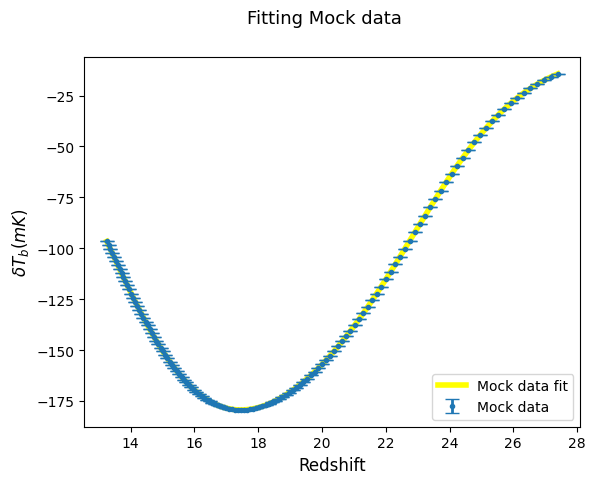

In [71]:
#mock data
plt.plot(z_e, T_fit_mock, label='Mock data fit', linewidth=4, color='yellow')
plt.errorbar(z_e, T_true, yerr=data_error_mock, fmt='.', capsize = 5, label='Mock data', linewidth=2)

plt.suptitle('Fitting Mock data', fontsize=13)
plt.xlabel('Redshift', fontsize=12)
plt.ylabel(r"$\delta T_b  \left(mK\right)$", fontsize=12)
plt.legend(loc = 'lower right')
plt.savefig('data.png')
#plt.xlim(22, 24)
#plt.ylim(-150, -75)

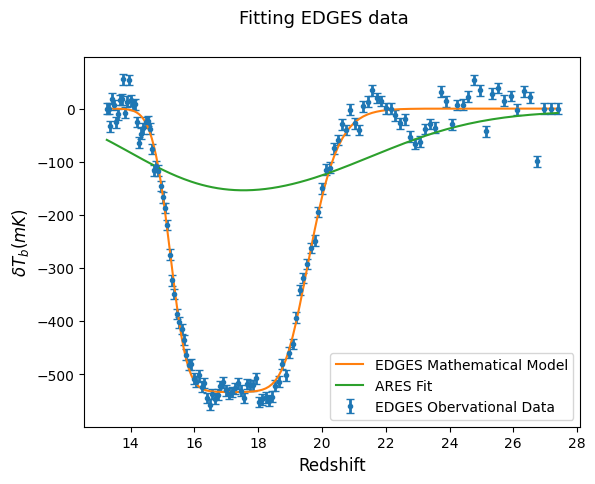

In [68]:
#EDGES
#plt.plot(z_e, data_e, label='EDGES Obervational Data')
plt.errorbar(z_e, data_e, yerr=data_error_edges, fmt='.', capsize = 3, label='EDGES Obervational Data', linewidth=2)

plt.plot(z_e, model_e, label='EDGES Mathematical Model')
plt.plot(z_e, T_edges, label='ARES Fit')

plt.suptitle('Fitting EDGES data', fontsize=13)
plt.xlabel('Redshift', fontsize=12)
plt.ylabel(r"$\delta T_b (mK)$", fontsize=12)
plt.legend(loc= 'lower right')
plt.savefig('data.png')